In [1]:
from dotenv import load_dotenv
import os
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage, AnyMessage 
from langgraph.checkpoint.memory import MemorySaver
from typing import List, Optional, Literal, Annotated
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command, interrupt
import sqlite3
from functions.prompts import SUPERVISOR_PROMPT, FUNDS_TRANSFER_PROMPT, PASSWORD_CHANGE_PROMPT
from functions.tools import bank_balance_check, transfer_funds, password_change_tool, SEARCH_TOOL, transfer_funds_tools, transfer_funds_tool_node

load_dotenv(".env")

True

# State Management

In [2]:
tools = transfer_funds_tools + [password_change_tool, SEARCH_TOOL]
llm = ChatOpenAI(model=os.getenv("OPENAI_MODEL_VERSION"), temperature=0, max_tokens=1000)
transfer_funds_llm = llm.bind_tools(transfer_funds_tools)
change_password_llm = llm.bind_tools([password_change_tool])
search_llm = llm.bind_tools([SEARCH_TOOL])

In [3]:
# members = ["transfer_assistant", "password_assistant", "web_search"]
members = ["transfer_assistant", "password_assistant"]

options = members + ["FINISH"]

system_prompt = SUPERVISOR_PROMPT

# class State(TypedDict):
#     """
#     State of the Chatbot
#     """
#     messages: Annotated[list[AnyMessage], add_messages]
#     user_info = str

class State(MessagesState):
    next: str

class Router(TypedDict):
    next: Literal[*options]

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# Context Memory Saving

In [4]:
memory = MemorySaver()

# Graph Building

In [5]:
fund_transfer_assistant = create_react_agent(
    transfer_funds_llm, tools = transfer_funds_tools, prompt = FUNDS_TRANSFER_PROMPT,
)

def funds_transfer_node(state: State) -> Command[Literal["supervisor"]]:
    result = fund_transfer_assistant.invoke(state)
    return Command(goto="supervisor", update={"messages": [HumanMessage(content=result["messages"][-1].content, name="fundsTransferAssistant")]})

In [6]:
password_change_assistant = create_react_agent(change_password_llm, tools=[password_change_tool], prompt = PASSWORD_CHANGE_PROMPT)

def password_change_node(state: State) -> Command[Literal["supervisor"]]:
    result = password_change_assistant.invoke(state)
    return Command(goto="supervisor", update={"messages": [HumanMessage(content=result["messages"][-1].content, name="passwordChangeAssistant")]})

In [7]:
search_assistant = create_react_agent(search_llm, tools=[SEARCH_TOOL], prompt = "What would you like me to search for?")    

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_assistant.invoke(state)
    return Command(goto="supervisor", update={"messages": [HumanMessage(content=result["messages"][-1].content, name="searchAssistant")]})

In [16]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    try:
        if last_message.tool_calls:
            return "transfer_assistant_tools"
    except AttributeError:
        return END
    return END

In [17]:
builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_edge(START, "supervisor")
builder.add_node("transfer_assistant", funds_transfer_node)
builder.add_node("transfer_assistant_tools", transfer_funds_tool_node)
builder.add_conditional_edges("transfer_assistant", should_continue, ["transfer_assistant_tools", END])
builder.add_edge("transfer_assistant_tools", "supervisor")
builder.add_node("password_assistant", password_change_node)
# builder.add_node("web_search", SEARCH_TOOL)
# builder.add_edge("web_search", "supervisor")
graph = builder.compile()

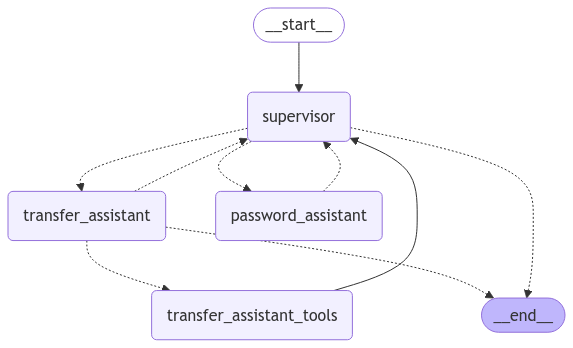

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# User Input/Testing the Graph

In [20]:
for chunk in graph.stream(
    {"messages": [("human", "I want to transfer 10 million dollars from account 987654321 to account 1357924680. My userid is 1234")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I want to transfer 10 million dollars from account 987654321 to account 1357924680. My userid is 1234
================================ Human Message =================================

I want to transfer 10 million dollars from account 987654321 to account 1357924680. My userid is 1234
================================ Human Message =================================
Name: fundsTransferAssistant

The bank balance in account 987654321 is insufficient to transfer 10 million dollars. Please check the account balance or consider transferring a different amount.
================================ Human Message =================================
Name: fundsTransferAssistant

The bank balance in account 987654321 is insufficient to transfer 10 million dollars. Please check the account balance or consider transferring a different amount.
